In [1]:
from netCDF4 import Dataset, num2date
import glob
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import describe
from tqdm import tqdm_notebook as tqdm

In [209]:
def load_netcdf(path = "Argo_South_60"):
    files = glob.glob("data/" + path + "/**/*.nc", recursive=True)
    print(len(files))

    lats = []
    lons = []
    datetimes = []
    sst = []

    for f in tqdm(files):
        d = Dataset(f)
        lat = d.variables["LATITUDE"][:]
        mask = lat < -60
        lon = d.variables["LONGITUDE"][:]
        lats.extend(lat[mask])
        lons.extend(lon[mask])
        juld = d.variables["JULD"][:]
        units = d.variables["JULD"].getncattr('units')
        dates = num2date(juld, units, "standard")
        datetimes.extend(dates)
        try:
            sst.extend(d.variables["TEMP_ADJUSTED"][mask,0])
        except:
            sst.extend(np.full(len(mask), np.nan))

    lats = np.array(lats)
    lons = np.array(lons)
    datetimes = np.array(datetimes)
    sst = np.array(sst)
    np.save(path + "_lats", lats)
    np.save(path + "_lons", lons)
    np.save(path + "_dts", datetimes)
    np.save(path + "_sst", sst)
    return lats, lons, datetimes, sst

def plot(lats, lons, z = [], title = "Argo profiles south of 60S", cbtitle = "Number of points in bin", vmax=None):
    # setup north polar stereographic basemap.
    # The longitude lon_0 is at 6-o'clock, and the
    # latitude circle boundinglat is tangent to the edge
    # of the map at lon_0. Default value of lat_ts
    # (latitude of true scale) is pole.
    fig = plt.figure(figsize=(15,15))
    m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='black',lake_color='aqua')
    # draw parallels and meridians.
    m.drawparallels(np.arange(-60, 0, 20))
    m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
    #m.drawmapboundary(fill_color='aqua')
    plt.title("{} {}".format(len(lats), title))

    x, y = m(lons, lats)
    if len(z) == 0:
        hh, locx, locy = np.histogram2d(x, y, bins=100)
        # Sort the points by density, so that the densest points are plotted last
        z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
        #print(describe(z))
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    #m.imshow(heatmap, interpolation='bicubic', cmap="jet")
    m.scatter(x, y, c=z, s=5, alpha=1, cmap="jet", vmax=vmax)
    cb = plt.colorbar()
    cb.set_label(cbtitle, rotation=270)
    plt.show()

def plot_time(dts, title, label):
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.hist(dts, bins=1000, label=label)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_title(title)
    ax.legend()
    plt.show()


1350


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Warning: converting a masked element to nan.


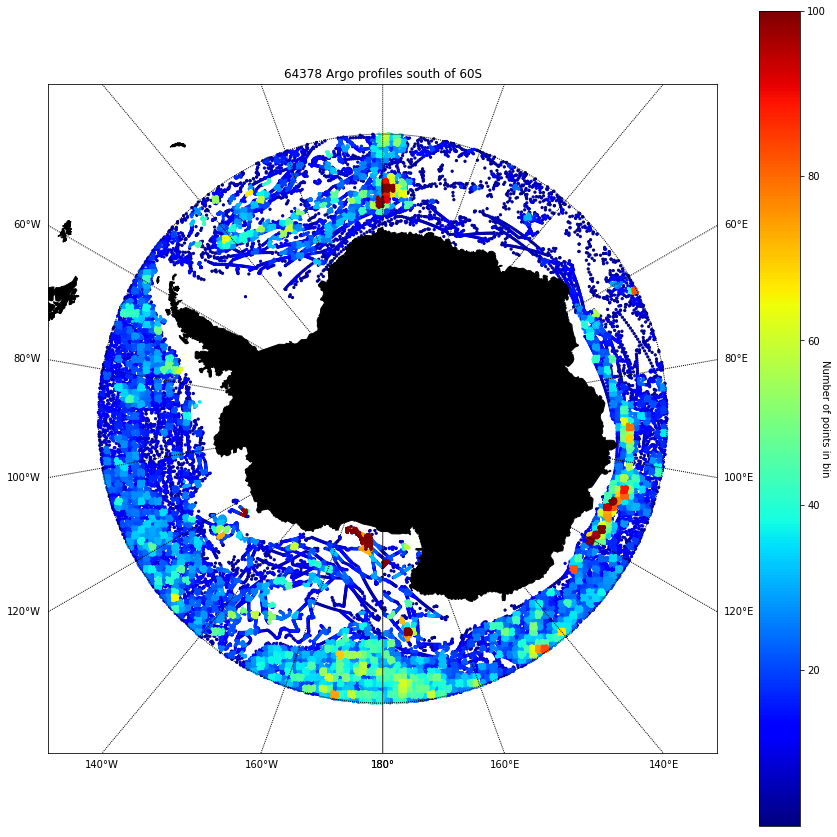

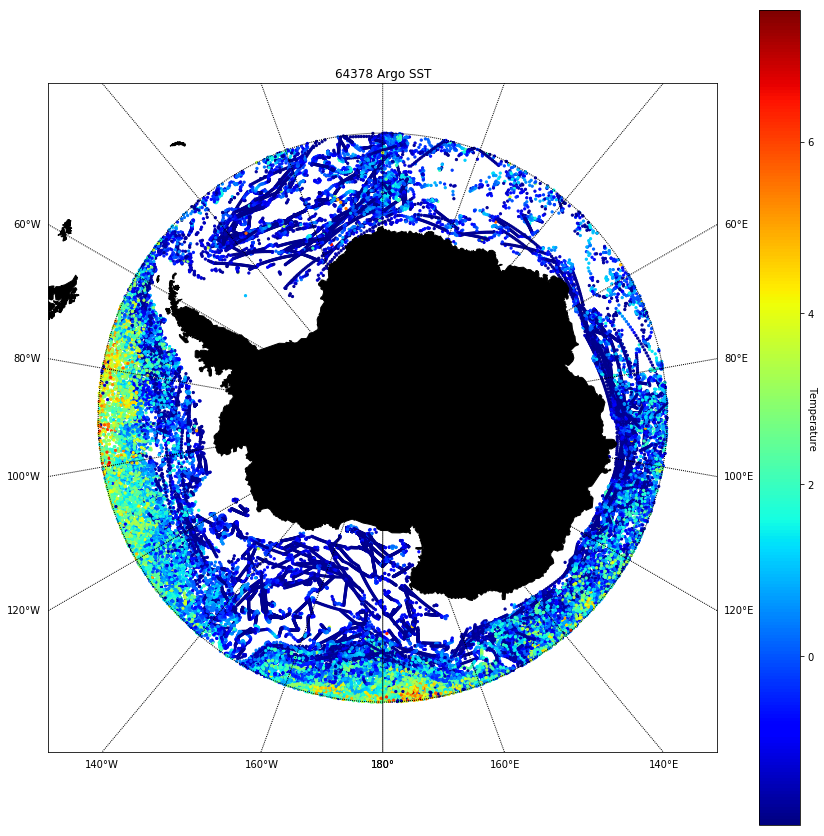

In [210]:
argo_lats, argo_lons, argo_dts, argo_sst = load_netcdf()
plot(argo_lats, argo_lons, vmax=100)
plot(argo_lats, argo_lons, argo_sst[:len(argo_lats)], title = "Argo SST", cbtitle = "Temperature")

2001-12-21 15:53:45 2019-07-04 19:53:14


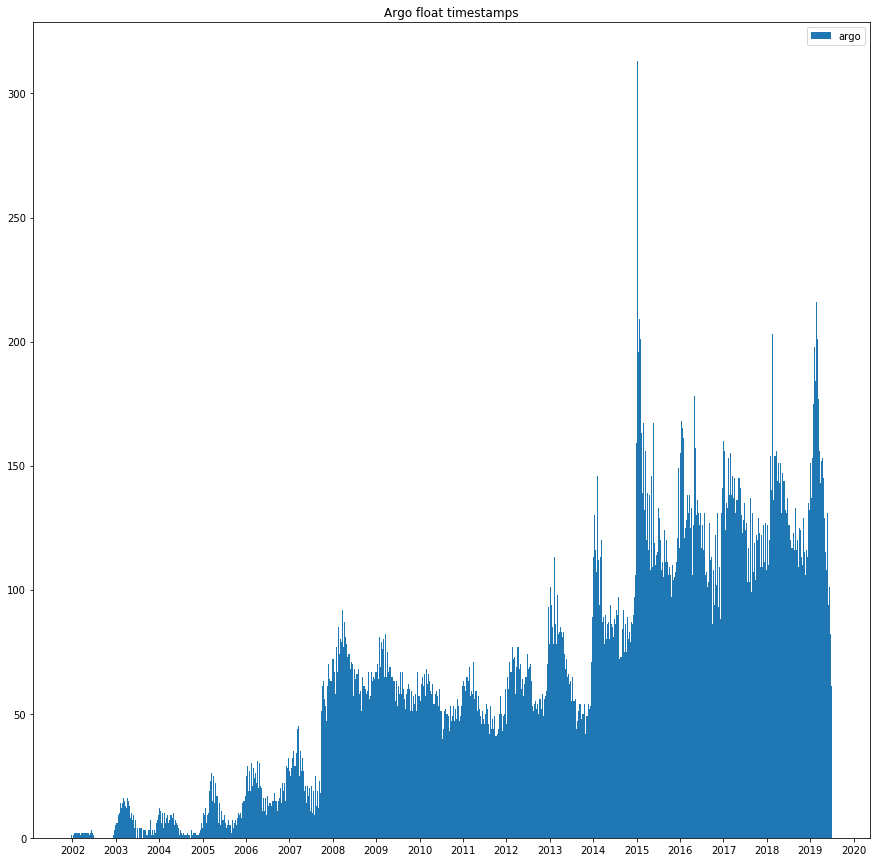

In [4]:
print(min(argo_dts), max(argo_dts))
plot_time(argo_dts, "Argo float timestamps", "argo")

748


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Warning: converting a masked element to nan.


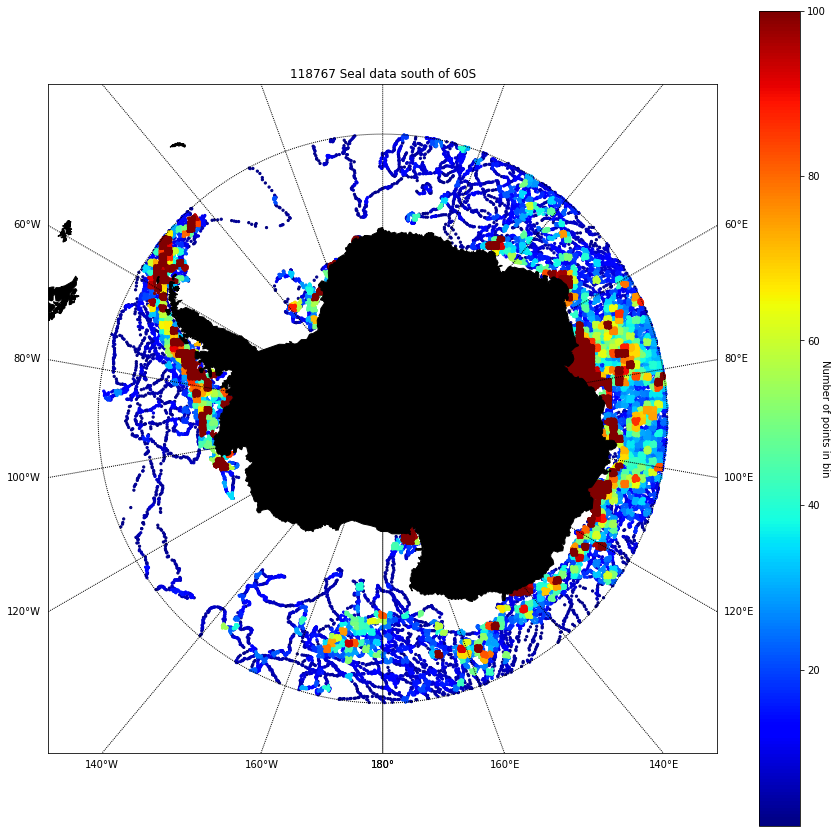

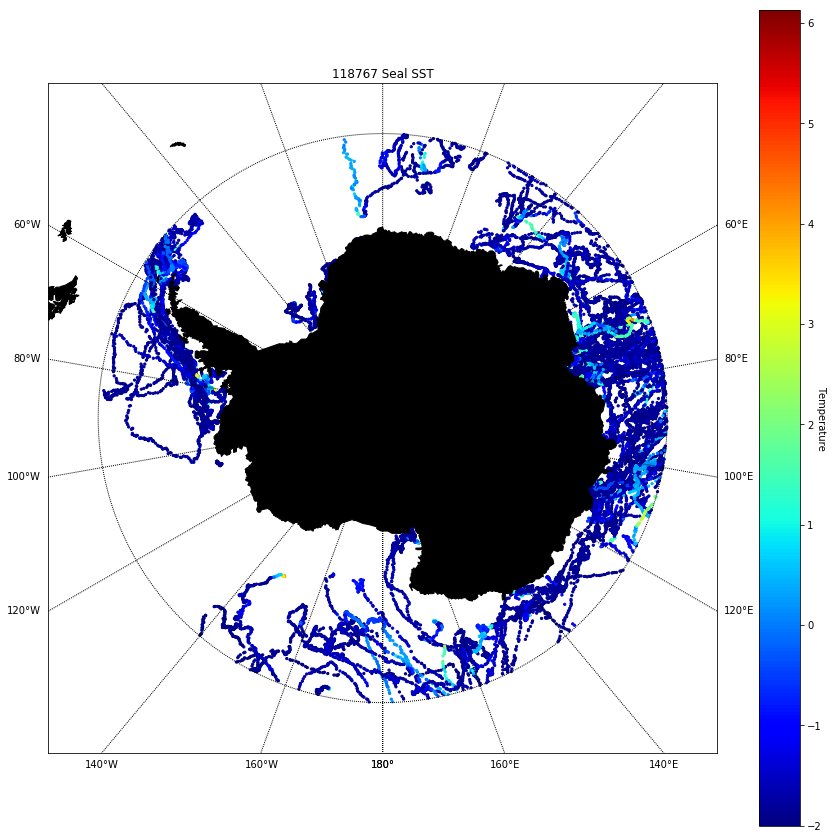

In [212]:
seal_lats, seal_lons, seal_dts, seal_sst = load_netcdf("seal")
plot(seal_lats, seal_lons, title = "Seal data south of 60S", vmax=100)
plot(seal_lats, seal_lons, seal_sst[:len(seal_lats)], title = "Seal SST", cbtitle = "Temperature")

2004-01-27 11:48:59.999999 2018-01-14 23:00:00.000003


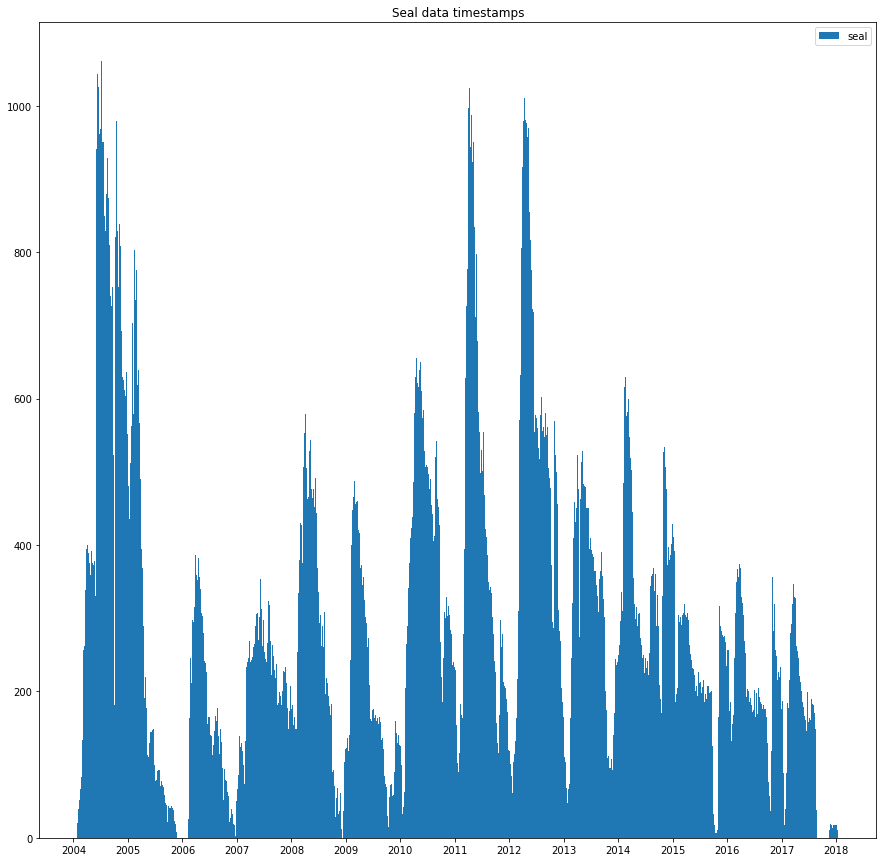

In [6]:
print(min(seal_dts), max(seal_dts))
plot_time(seal_dts, "Seal data timestamps", "seal")

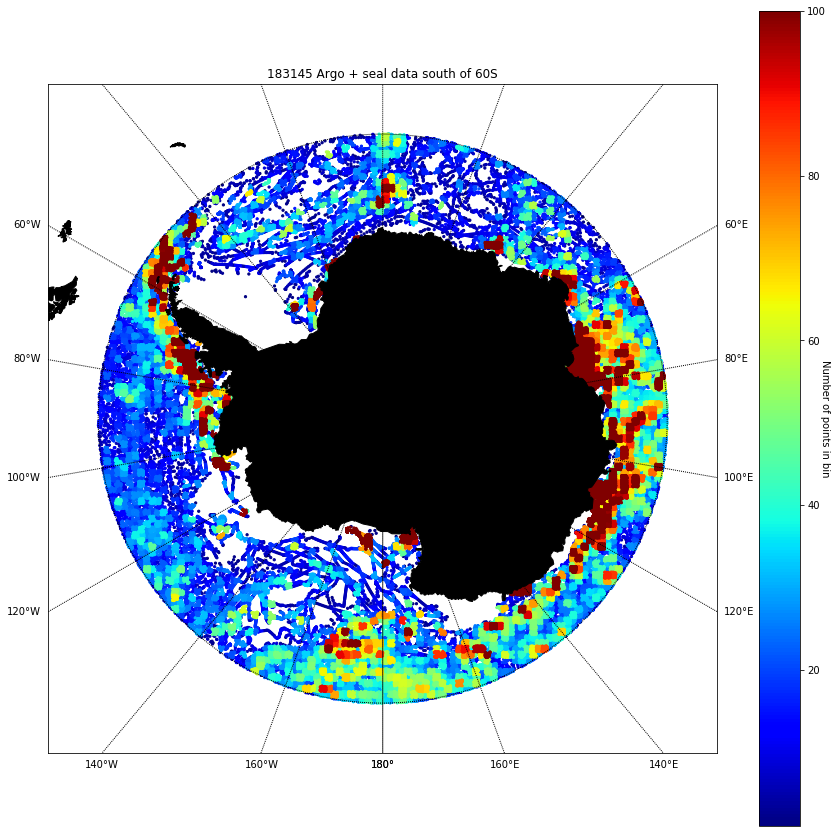

In [214]:
all_lats = np.concatenate((seal_lats, argo_lats))
all_lons = np.concatenate((seal_lons, argo_lons))
plot(all_lats, all_lons, title="Argo + seal data south of 60S", vmax=100)

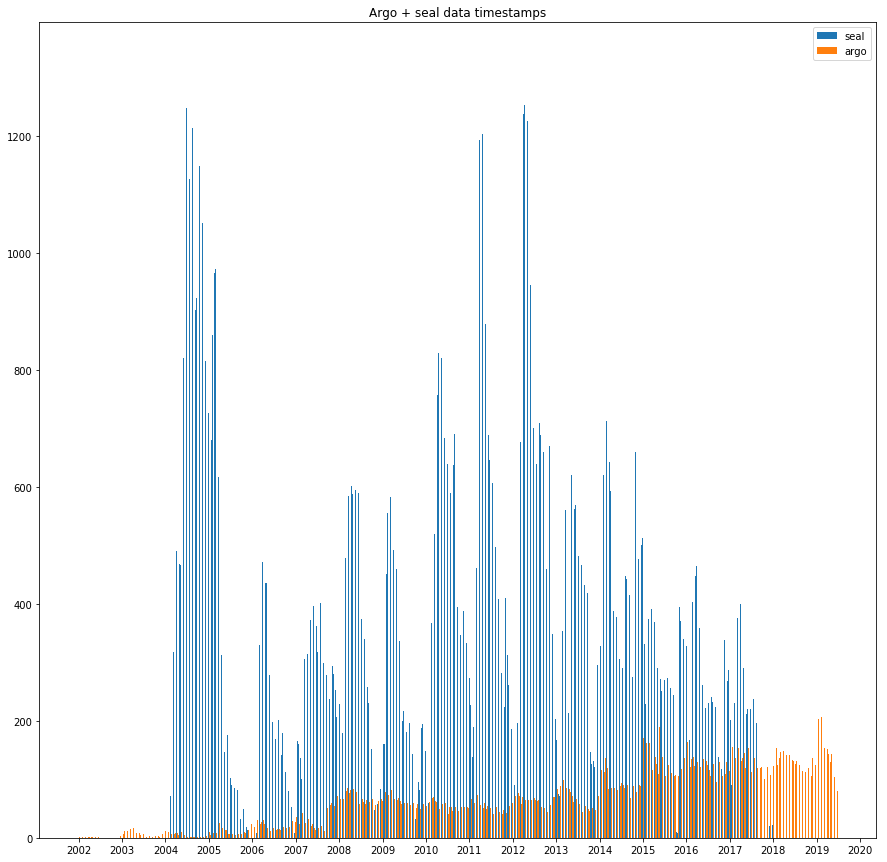

In [8]:
plot_time((seal_dts, argo_dts), "Argo + seal data timestamps", ["seal", "argo"])

In [174]:
grid = np.zeros(shape=[15, 360])
files = glob.glob("data/seal/*.nc", recursive=True)
print(len(files))

for f in tqdm(files[:]):
    d = Dataset(f)
    lat = d.variables["LATITUDE"][:]
    mask = (lat < -60) & (lat > -74.5)
    if any(mask):
        lat = np.round(np.abs(lat[mask]) - 60).astype(int)
        lon = d.variables["LONGITUDE"][mask]
        lon = np.round(lon + 180).astype(int)
        lon[lon == 360] = 0
        #pres = np.round(d.variables["PRES_ADJUSTED"][mask] / 10).astype(int)
        temp = d.variables["TEMP_ADJUSTED"][mask, 0]
        for x in lon:
            mean_for_lon = np.nanmean(temp[lon == x])
        for ix, x in enumerate(lon):
            for iy, y in enumerate(lat):
                grid[y, x] = (grid[y, x] + temp[ix]) / 2

#print(m)
                    

748


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Warning: converting a masked element to nan.


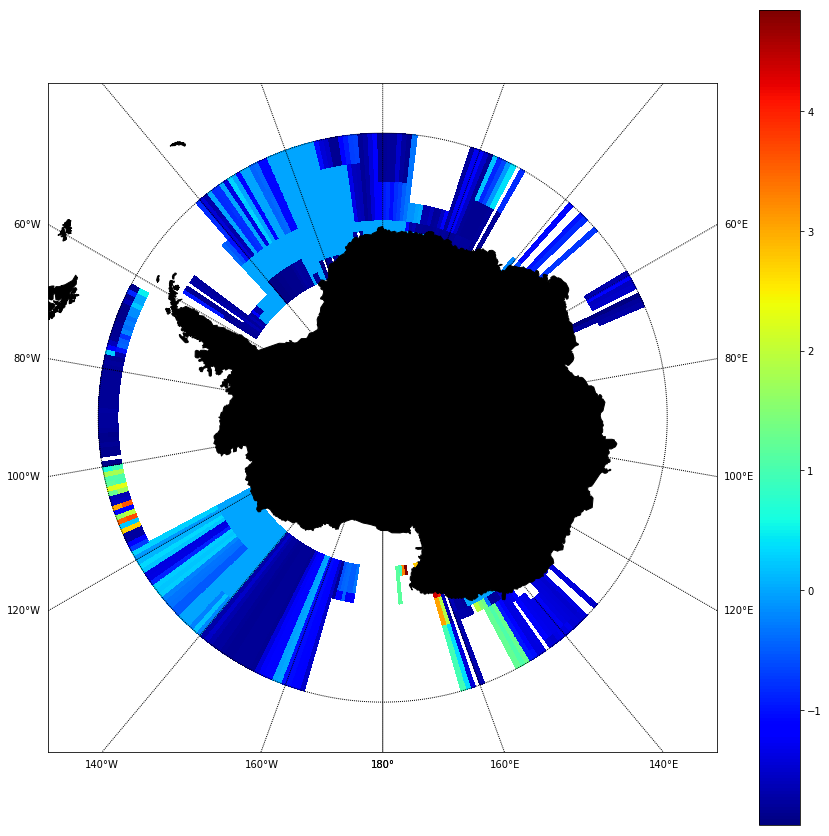

In [175]:
fig = plt.figure(figsize=(15,15))
m = Basemap(projection='spstere',boundinglat=-55,lon_0=180,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='black',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-60, 0, 20))
m.drawmeridians(np.arange(-180, 181, 20), labels=[1,1,0,1])
#m.drawmapboundary(fill_color='aqua')
#plt.title("{} {}".format(len(lats), title))

x = np.arange(-180, 180, 1)
y = np.arange(-60, -75, -1)
x, y = np.meshgrid(x, y)
x, y = m(x, y)

m.pcolormesh(x, y, grid, cmap="jet")
cb = plt.colorbar()
plt.show()